<a href="https://colab.research.google.com/github/daniel8691/Image_Rec_Tensorflow/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import files
import json
import zipfile
import os



In [67]:
# used to delete folders with data
# !rm -rf "train"

In [68]:
# !unzip "drive/MyDrive/Dog_breed_project/dog_breed_data/dog-breed-identification.zip" -d "drive/MyDrive/Dog_breed_project/dog_breed_data"

## Problem
Identifying the breed of a dog given an image of a dog

WHen I take a photo of a dog, I want to know what breed of dog it is

## Data
The data was taken from Kaggle's dog breed identification competition: https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation
This will be a file with prediction probabilities for each dog breed of each test image: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features
* dealing with images (unstructured data) so it's best to use deep learning/transfoer learning
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we want to predict them


In [69]:
# import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:"+tf.__version__)
print(f"TFhub version: {hub.__version__}")

# Check for GPU availability
if tf.config.list_physical_devices("GPU"):
  print("Available")
else:
  print("not available")

TF version:2.4.1
TFhub version: 0.11.0
Available


## Get data ready (turn into Tensors)

The data has to be in numerical format for the ML model
Turn the images into numerical values (numerical representations)

Start by assessing the data and checking out the labels


In [70]:
# check out the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/labels.csv")

In [71]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,b7cc2933c599642388ff6d446bbef59f,scottish_deerhound
freq,1,126


In [72]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [73]:
# check how many images each dog breed has
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

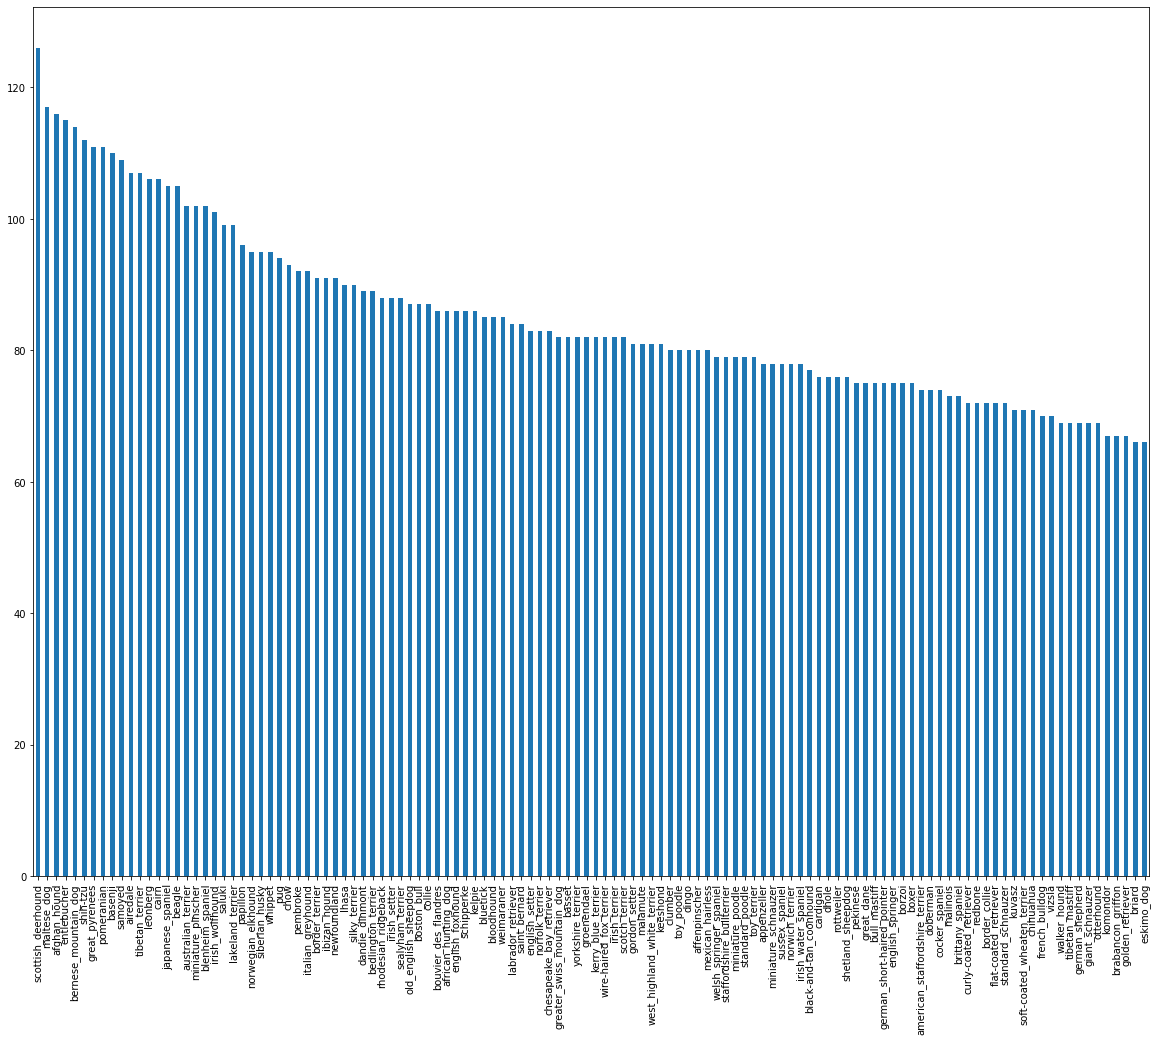

In [74]:
labels_csv['breed'].value_counts().plot(kind='bar', figsize=(20,16))

In [75]:
labels_csv['breed'].value_counts().median()

82.0

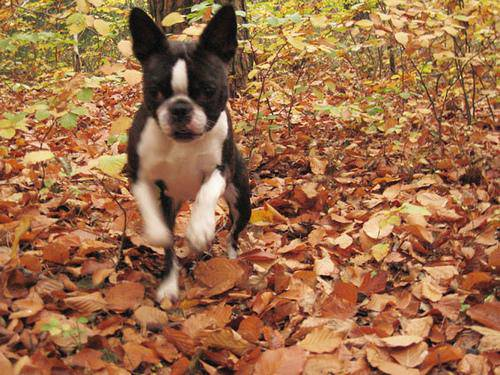

In [76]:
# view an image
from IPython.display  import Image
# pass in file name
Image("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting Images and their labels

get a list of all the image file path names

In [77]:
labels_csv['id'].count()

10222

In [78]:
# Create pathnames from image ID's
fileNames = [fname for fname in labels_csv['id']]

In [79]:
# check the first 10
fileNames[:5]

['000bec180eb18c7604dcecc8fe0dba07',
 '001513dfcb2ffafc82cccf4d8bbaba97',
 '001cdf01b096e06d78e9e5112d419397',
 '00214f311d5d2247d5dfe4fe24b2303d',
 '0021f9ceb3235effd7fcde7f7538ed62']

In [80]:
# get the file names with its file path 
fileNames_path = [f"/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/{fname}.jpg" for fname in labels_csv['id']]

In [81]:
fileNames_path[:5]

['/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [82]:
# check codes
import os
os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")[:10]

['ed650c72271b58dbac0fd5d91ebd206b.jpg',
 'f0efab499435ecd4e634b72f539fde9b.jpg',
 'efd68fb69d154ed0ff2dfea8f782f0d3.jpg',
 'ee92839020f1795e7eab77358e2528f1.jpg',
 'ea77bbe28a68e90a21bbef677493ad65.jpg',
 'f3929a0a7c3fede11ceb5d9e379778db.jpg',
 'f243cb6ec376a19f7de80e9c1a248518.jpg',
 'ecc1a9dcc73f00726ce6a7e79ef10a1c.jpg',
 'f2d5c11258efb9e8de45a81a6982f8f2.jpg',
 'ea9134791fb20bce0b72caabfa0947a6.jpg']

In [83]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")) == len(fileNames_path):
  print("Filenames match actual number of files")
else:
  print("filenames don't match actual number of files")


Filenames match actual number of files


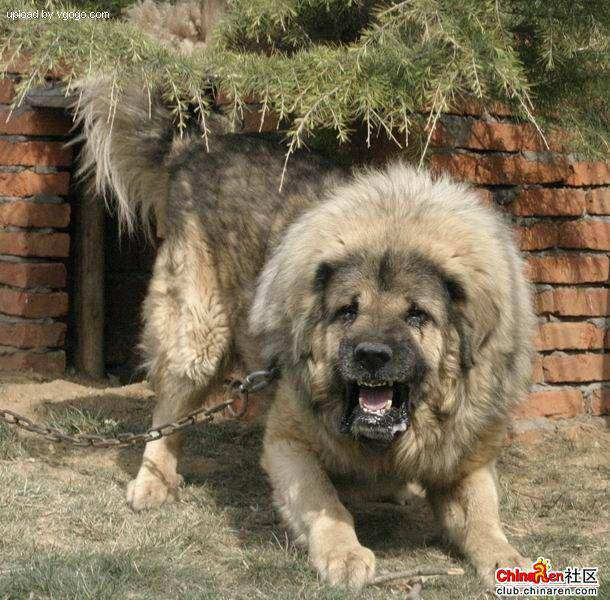

In [84]:
Image(fileNames_path[9000])

In [85]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filpaths in a list, let's prepare the labels

In [86]:
import numpy as np
labels = labels_csv['breed']
labels = np.array(labels)
# labels = label_csv['breed].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [87]:
len(labels)

10222

In [88]:
# check if number of labels matches the number of filenames
if len(labels) == len(fileNames_path):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels doesn't match number of filenames")

Number of labels matches number of filenames


In [89]:
# find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [90]:
# should have 120 unique values (stated in the Kaggle description)
len(unique_breeds)

120

In [91]:
# Turn a single label into an arry of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [92]:
# Turn every single label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [93]:
print(len(boolean_labels))

10222


In [94]:
# example: turning boolean array into integers
print(labels[0])
# index where label occurs
print(np.where(unique_breeds == labels[0]))
# indent where label occurs in boolean array
print(boolean_labels[0].argmax()) 
# there should be a 1 where the sample label occurs
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [95]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

since the dataset from kaggle doesn't come with a validaiton set, we have to create our own

Here we'll start off experimenting with ~1000 images and increase as needed (training all the data takes too long)

In [96]:
# set up X & y variables
X = fileNames_path
y = boolean_labels

In [97]:
len(fileNames_path)

10222

In [98]:
len(boolean_labels)

10222

In [99]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [100]:
# split data into train and validation data
from sklearn.model_selection import train_test_split
# split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  #reproducible results
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [101]:
# have a look at the training data
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,

## Preprocess images (turning images into Tensors)

To preprocess images into Tensors: write a function that:
* Take an image filepath as input
* Use Tensorflow to read the file and save it to a variable, `image`
* Turn `image` (a jpg) into Tensors
* Normalize images (convert color channel values from 0-255 to 0-1)
* Resize the `image` to be a shape of (224,224)


https://www.tensorflow.org/guide/data

https://www.tensorflow.org/tutorials/load_data/images


Before creating the function, check what importing an image looks like

In [102]:
# Convert an image to NumPy
from matplotlib.pyplot import imread
image = imread(fileNames_path[42])
# height, width, color channel (ie. red, green)
image.shape

(257, 350, 3)

In [103]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [104]:
image.max(), image.min()

(255, 0)

In [105]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [106]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

image[:2] and tf.constant(image)[:2]: `image` is an array and `tf.constant(image)` is a tensor. The difference is that the tensor is in Tensorflow and that it's able to run on a GPU (so a lot faster to compute). So finding patterns within the numbers will be much faster than the CPU

In [107]:
# turn into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

* Take an image filepath as input
* Use Tensorflow to read the file and save it to a variable, `image`
* Turn `image` (a jpg) into Tensors
* Normalize images (convert color channel values from 0-255 to 0-1)
* Resize the `image` to be a shape of (224,224)

In [108]:
# test codes
tensor = tf.io.read_file(fileNames_path[26])
# turns file into long tensor
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [109]:
# test codes
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [110]:
tensor[:2]

<tf.Tensor: shape=(2, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]]], dtype=uint8)>

In [111]:
# same shape, but now the numerical values are NORMALIZED
tensor = tf.image.convert_image_dtype(tensor, tf.float32)
tensor

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

In [112]:
tf.image.resize(tensor, size=[224,224])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.25410587, 0.2894    , 0.2776353 ],
        [0.29784313, 0.33313724, 0.32137254],
        [0.29804096, 0.33333507, 0.32157037],
        ...,
        [0.41461015, 0.46559054, 0.38715917],
        [0.44833592, 0.4993163 , 0.42088494],
        [0.44921985, 0.5002003 , 0.42176887]],

       [[0.27608263, 0.31137675, 0.29961205],
        [0.30547515, 0.34076926, 0.32900456],
        [0.2880393 , 0.3233334 , 0.3115687 ],
        ...,
        [0.41783687, 0.46881726, 0.3903859 ],
        [0.46009547, 0.51107585, 0.4326445 ],
        [0.48616162, 0.537142  , 0.45871064]],

       [[0.29875293, 0.33404705, 0.3144392 ],
        [0.27189255, 0.30718666, 0.28757882],
        [0.28608775, 0.32138187, 0.30177402],
        ...,
        [0.47503573, 0.5260161 , 0.44758475],
        [0.49345425, 0.54443467, 0.46600327],
        [0.4703167 , 0.5212971 , 0.44286573]],

       ...,

       [[0.77551085, 0.7260472 , 0.59820485],
        [0.86

In [113]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """

  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue) (3 channels)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to the desired value (224,224) - into a square
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image

## Turning data into batches

Why turn data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory

So that's why we do about 32 (batch size) images at a time (you can manually adjust the batch size if needed).

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this: 
`(image,label)` 

In [114]:
# Create a simple function to return a tuple (image, label). tuple of Tensors
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image nad returns a tuple of (image,label).
  """
  image = process_image(image_path)

  return image,label

In [115]:
# process image and turn file into tensor
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn the data into tuples of Tensors in the form `(image,label)`, lets make a function to turn all of the data (`X`,`y`) into batches

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch

In [116]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs. 
  Shuffles the data if it's training data but doesn't shuffle if it's validation data
  Also accespts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    # make a batch dataset
    # this passes in Tensors, and create a dataset
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) #only filepaths (no labels)
    # turn into batch size of 32
    data_batch = data.map(process_image).batch(BATCH_SIZE)

    return data_batch

  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                              tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle pathnames and labels before mapping image processor function is faster than shuffling images
    # buffer_size: how many variables we want to shuffle and we want to shuffle the whole data
    data = data.shuffle(buffer_size=len(X))
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [117]:
# create training and validation data
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [118]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec
# this shoulds (shape=("batches size", "shape of 224,224,3"))

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understnad/comprehend. Let's visualize

In [119]:
# function code testing
unique_breeds[y[0].argmax()]

'boston_bull'

In [120]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # Set up the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1)
    # Display an image (show the ith image)
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [121]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [122]:
train_data.as_numpy_iterator()

In [123]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.61211413, 0.7245179 , 0.3133044 ],
          [0.6556716 , 0.76807535, 0.356555  ],
          [0.62702847, 0.73228055, 0.32358074],
          ...,
          [0.6493446 , 0.75770307, 0.3534663 ],
          [0.6049915 , 0.7391208 , 0.36531273],
          [0.6398634 , 0.7776258 , 0.4131829 ]],
 
         [[0.565743  , 0.68334633, 0.3022728 ],
          [0.55495274, 0.67255604, 0.28968206],
          [0.66400206, 0.7692175 , 0.39002272],
          ...,
          [0.59453624, 0.7053695 , 0.30514193],
          [0.6612255 , 0.7997081 , 0.39894435],
          [0.5308768 , 0.6735859 , 0.27669987]],
 
         [[0.5916661 , 0.7080789 , 0.35804394],
          [0.59415615, 0.71056896, 0.36053392],
          [0.66125417, 0.7685897 , 0.4224762 ],
          ...,
          [0.5797941 , 0.7030142 , 0.31344545],
          [0.6002444 , 0.7477987 , 0.32201084],
          [0.5458719 , 0.6990319 , 0.26184702]],
 
         ...,
 
         [[0.21508391, 0.3680251 , 0.01637524],
          [0.30226

In [124]:
len(train_images), len(train_labels)

(32, 32)

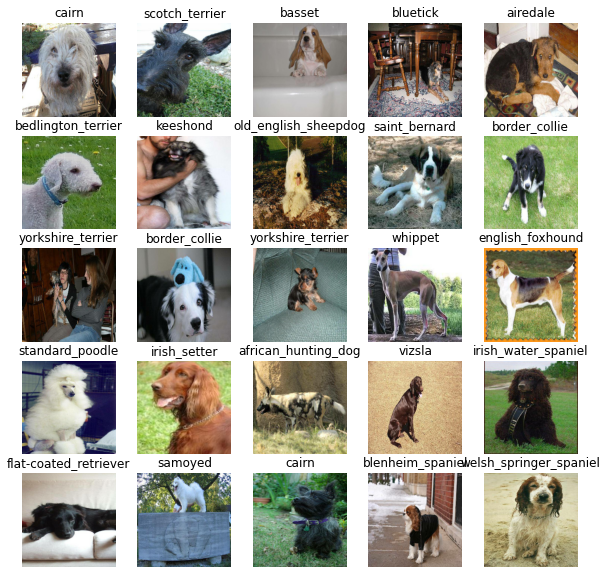

In [130]:
# Now let's visualize the data in a training batch
show_25_images(val_images, val_labels)

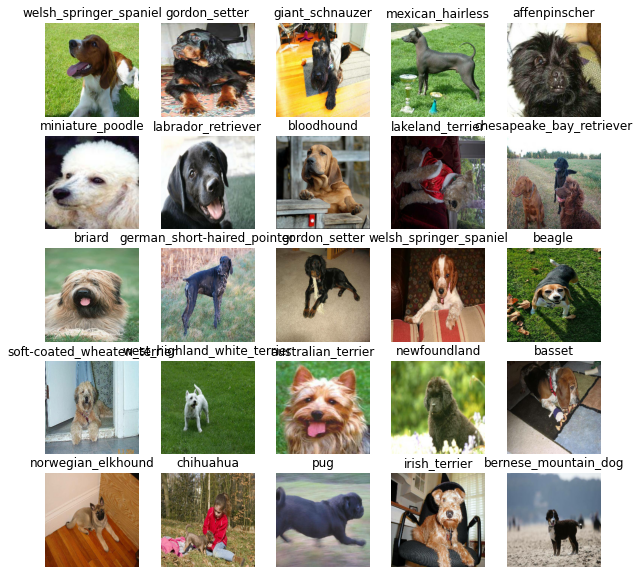

In [126]:
# Now let's visualize the validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The `input` shape (our images shape, in the form of Tensors) to our model.
* The `output` shape(image labels, in the form of Tensors) of our model
* The URL of the model we want to use
* The URL of the model we want to use from Tensorflow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


**Input an image, find some patterns within that image and then if we fed it an image in the future (what it hasnt seen before, we'd like it to find patterns in that image, and output an array of length unique labels, which hopefully contains the correct label**


In [127]:
IMG_SIZE

224

In [128]:
len(unique_breeds)

120

In [129]:
# Set up input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Set up output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Set up model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go,. Lets put them together into a Keras deep learning model

Knwoing this, create a function which:
* takes the input shape, output shape, and the model we've chosen as parameters
* Defines the layers in aKeras model in a sequential fashion (ie. do this first, then this, then that).

* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [133]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Set up the model layers
  model = tf.keras.Sequential([
                              #  Create a keras layer of MODEL_URL
                               hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation='softmax') #Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [135]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


1. we have an input image, then mobilenet has a bunch of layers (feature learning) built into it. It looks at the input image, do some data transformations on it and then output it to something (ie. a list of numbers)

input 224^2 x 3 and output 1x1x1280 (last layer)


https://en.wikipedia.org/wiki/Softmax_function
* After applying softmax, each component will be in the interval (0,1) and the components will add up to 1, so that they can be interpreted as probabilities
* If we're working with **Binary Classification**, the  activation function is `Sigmoid`. If we're working with **Multi-class classification**, the activation function is `softmax` (what we used for this project)


In [136]:
outputs = np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])